## Create and Process Data for modelling

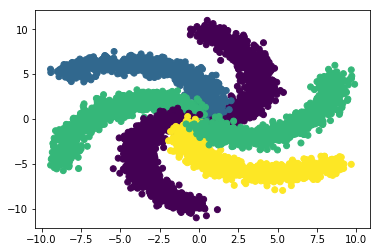

In [19]:
import numpy as np
import matplotlib.pyplot as plt
def get_spiral():
    # Idea: radius -> low...high
    #           (don't start at 0, otherwise points will be "mushed" at origin)
    #       angle = low...high proportional to radius
    #               [0, 2pi/6, 4pi/6, ..., 10pi/6] --> [pi/2, pi/3 + pi/2, ..., ]
    # x = rcos(theta), y = rsin(theta) as usual

    radius = np.linspace(1, 10, 1000)
    thetas = np.empty((6, 1000))
    for i in range(6):
        start_angle = np.pi*i / 3.0
        end_angle = start_angle + np.pi / 2
        points = np.linspace(start_angle, end_angle, 1000)
        thetas[i] = points

    # convert into cartesian coordinates
    x1 = np.empty((6, 1000))
    x2 = np.empty((6, 1000))
    for i in range(6):
        x1[i] = radius * np.cos(thetas[i])
        x2[i] = radius * np.sin(thetas[i])

    # inputs
    X = np.empty((6000, 2))
    X[:,0] = x1.flatten()
    X[:,1] = x2.flatten()

    # add noise
    X += np.random.randn(6000, 2)*0.5

    # targets
    Y = np.array([0]*1000 + [1]*1000 + [2]*1000 + [0]*1000 + [3]*1000 + [2]*1000)
    return X, Y

X,y=get_spiral()

plt.scatter(X[:,0],X[:,1],c=y)
plt.show()

In [20]:
def one_hot_encoder(X):
    N=X.shape[0]
    K=len(np.unique(X))
    Z=np.zeros((N,K))
    for i in range(N):
        c=X[i]
        Z[i,c]=1
    return Z
y_i=one_hot_encoder(y)

In [21]:
def standardize(X):
    stds=X.std(axis=0)
    means=X.mean(axis=0)
    X=(X-means)/stds
    return X,means,stds

In [22]:
X_s,m,s=standardize(X)

In [23]:
X_s

array([[ 0.32932187, -0.19626317],
       [ 0.2274151 , -0.06250061],
       [ 0.24234489,  0.03614837],
       ...,
       [ 1.91383987,  1.13254589],
       [ 1.9376584 ,  1.12855014],
       [ 2.02741955,  1.07798227]])

In [24]:
def train_test_split(X,y,size=0.8,rs=None):
    N=len(X)
    np.random.seed(rs)
    tr_i=np.random.choice(N,int(size*N),replace=False)
    t_i=[i for i in range(N) if i not in tr_i]
    X_train=X[tr_i]
    y_train=y[tr_i]
    X_test=X[t_i]
    y_test=y[t_i]
    return X_train,y_train,X_test,y_test

In [25]:
X_train,y_train,X_test,y_test=train_test_split(X_s,y,size=0.9,rs=20)

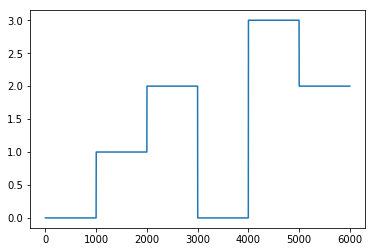

In [26]:
plt.plot(y)

In [27]:
y_i.shape

(6000, 4)

In [28]:
-np.log(y_i[995:1005,y[1000:1010]]).mean()

inf

## Create ANN

In [29]:
import theano
from theano import tensor as T

In [30]:
class HiddenLayer(object):
    def __init__(self,M1,M2,i):
        self.id=i
        self.M1=M1
        self.M2=M2
        W=np.random.randn(M1,M2)/np.sqrt(M1)
        b=np.random.randn(M2)
        self.W=theano.shared(W,name='W{0}'.format(i))
        self.b=theano.shared(b,name='b{0}'.format(i))
        self.params=[self.W,self.b]
    def forward(self,X,activation='relu'):
        if activation=='tanh':
            return T.tanh(X.dot(self.W)+self.b)
        elif activation=='sigmoid':
            return T.nnet.sigmoid(X.dot(self.W)+self.b)
        else:
            return T.nnet.relu(X.dot(self.W)+self.b)
    

In [74]:
class ANN(object):
    def __init__(self,hidden_layer_size):
        self.hidden_layer_size=hidden_layer_size
    def forward(self,X):
        z=X
        for h in self.hidden_layers:
            z=h.forward(z)
        return T.nnet.softmax(z.dot(self.W)+self.b)
    def predict(self,X):
        p=self.forward(X)
        return T.argmax(p,axis=1)
    def fit(self,X,y,lr=0.001,epochs=1000,mu=0.99,show_fig=True):
        X_t,y_t,X_v,y_v=train_test_split(X,y,size=0.9,rs=100)
        c_t=[]
        c_v=[]
        cl_t=[]
        cl_v=[]
        N,D=X_t.shape
        self.hidden_layers=[]
        M1=D
        cnt=0
        for M2 in self.hidden_layer_size:
            h=HiddenLayer(M1,M2,cnt)
            self.hidden_layers.append(h)
            M1=M2
            cnt+=1
        M2=len(set(y_t))
        W=np.random.randn(M1,M2)/np.sqrt(M1)
        b=np.random.randn(M2)
        self.W=theano.shared(W,name='W_f')
        self.b=theano.shared(b,name='b_f')
        self.params=[self.W,self.b]
        for h in self.hidden_layers:
            self.params+=h.params
        thX=T.matrix('X')
        thY=T.ivector('y')
        y_p=self.forward(thX)
        cost=-T.mean(T.log(y_p[T.arange(thY.shape[0]),thY]))
        preds=self.predict(thX)
        cost_preds=theano.function(inputs=[thX,thY],outputs=[cost,preds])
#         updates=[(p,(p-lr*T.grad(cost,p)) )for p in self.params]
        grads=T.grad(cost,self.params)
        vparams=[theano.shared(np.zeros_like(p.get_value())) for p in self.params]
        updates=[(p,p+mu*v-lr*g) for p,g,v in zip(self.params,grads,vparams)]
        train=theano.function([thX,thY],updates=updates)
        for i in range(epochs):
            c,p=cost_preds(X_v,y_v)
            c_v.append(c)
            cl_v.append(np.mean(p==y_v))
            c,p=cost_preds(X_t,y_t)
            c_t.append(c)
            cl_t.append(np.mean(p==y_t))
            train(X_t,y_t)
            if i %100==0:
                print('Epoch {0} Train C: {1} Cl: {2} Test C: {3} Cl:{4}'.format(i,c_t[i],cl_t[i],c_v[i],cl_v[i]))
#                 print('Epoch {0} Train C: {1} Test C: {2}'.format(i,c_t[i],c_v[i]))

            
        
        

In [75]:
ann=ANN((5,10,20,60,7,10))

In [76]:
ann.fit(X_train,y_train,lr=0.01,epochs=5000)

Epoch 0 Train C: 1.827447619542631 Cl: 0.3339506172839506 Test C: 1.8858861884121219 Cl:0.3351851851851852
Epoch 100 Train C: 1.302326323549367 Cl: 0.408641975308642 Test C: 1.312699190445341 Cl:0.4
Epoch 200 Train C: 1.283753720978392 Cl: 0.41831275720164607 Test C: 1.2919285385138894 Cl:0.4111111111111111
Epoch 300 Train C: 1.2538150909431107 Cl: 0.42242798353909466 Test C: 1.2589452100104028 Cl:0.412962962962963
Epoch 400 Train C: 1.2034644418033809 Cl: 0.4191358024691358 Test C: 1.2041101464473145 Cl:0.412962962962963
Epoch 500 Train C: 1.1256218747308984 Cl: 0.41502057613168725 Test C: 1.1181156194312107 Cl:0.4148148148148148
Epoch 600 Train C: 1.0259330826098807 Cl: 0.5187242798353909 Test C: 1.0119689809691346 Cl:0.5166666666666667
Epoch 700 Train C: 0.9087687194230367 Cl: 0.5960905349794239 Test C: 0.8905345395897188 Cl:0.6277777777777778
Epoch 800 Train C: 0.7924537745926181 Cl: 0.6393004115226337 Test C: 0.7701544754655002 Cl:0.6648148148148149
Epoch 900 Train C: 0.7021146434

In [77]:
thX=T.matrix('X_test')
preds=ann.predict(thX)
f=theano.function([thX],outputs=preds)

In [78]:
y_p_test=f(X_test)

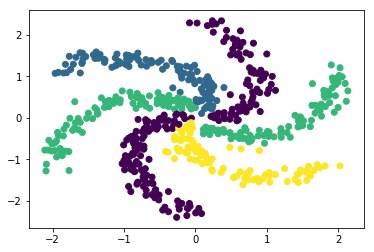

In [79]:
plt.scatter(X_test[:,0],X_test[:,1],c=y_p_test)
plt.show()

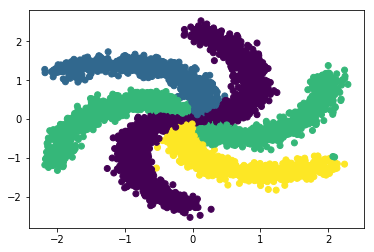

In [80]:
y_p_train=f(X_train)
plt.scatter(X_train[:,0],X_train[:,1],c=y_p_train)
plt.show()

In [67]:
a=x[1]

NameError: name 'x' is not defined

In [104]:
f=theano.function(inputs=[],outputs=[a])

In [105]:
f()

[array(1, dtype=int64)]